### Basin polygons of European rivers are overlaid on a global raster map using a mask to isolate Europe from the raster data. 
Data source https://www.hydrosheds.org/
            https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/bedrock/grid_registered/georeferenced_tiff/ETOPO1_Bed_g_geotiff.zip

In [114]:
%reset -f

In [115]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import itertools
from rasterio.plot import show
from rasterio import mask as msk 
from shapely.geometry import mapping
from shapely.ops import unary_union
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib import cm

In [116]:
# Open the GeoTIFF file for reading
rst = rasterio.open('../resources/geotiff.tif')

# Read the image data from the GeoTIFF file
image = rst.read()

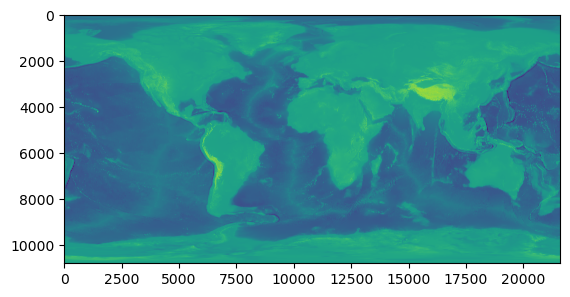

In [117]:
# Display the first band of the image
plt.imshow(image[0])
plt.show()

<Axes: >

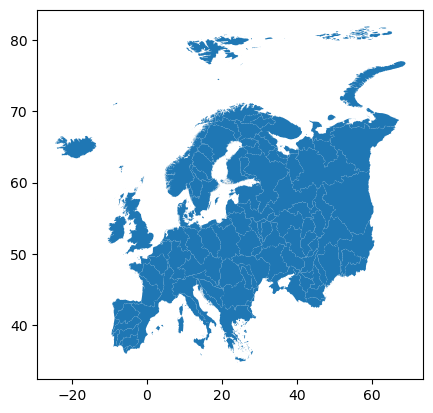

In [118]:
# Read the shapefile containing basin geometries for Europe
basins = gpd.read_file('../resources/Europe/hybas_eu_lev04_v1c.shp')
basins.plot()

In [119]:
print(basins.head())

     HYBAS_ID   NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  2040005690           0  2040005690  2040005690        0.0        0.0   
1  2040006590           0  2040006590  2040006590        0.0        0.0   
2  2040501940  2040006590  2040006590  2040006590      100.0      100.0   
3  2040501810  2040006590  2040006590  2040006590      100.1      100.1   
4  2040491980  2040501810  2040006590  2040006590      188.1      188.1   

   SUB_AREA   UP_AREA  PFAF_ID  ENDO  COAST  ORDER  SORT  \
0  105556.4  105556.4     2220     0      1      0    11   
1    7570.9  437307.8     2231     0      0      1    12   
2   50350.4   50350.4     2232     0      0      2    13   
3   21791.6  379756.5     2233     0      0      1    14   
4   55753.3  259243.0     2235     0      0      1    15   

                                            geometry  
0  MULTIPOLYGON (((38.34444 46.75833, 38.32015 46...  
1  POLYGON ((39.13750 47.73750, 39.13715 47.73992...  
2  POLYGON ((44.14583 4

In [120]:
print(basins['MAIN_BAS'].nunique())

102


In [121]:
# List of color hex codes representing different colors
colours_list = ['#A1CAF1',  '#875692', '#008856',  '#0067A5', '#BE0032',
                  '#222222', '#848482', '#F3C300',  'blue', '#F38400',
                  '#E68FAC', '#604E97', '#F3C300', '#B3446C', '#C2B280', 
                  '#F6A600', '#882D17', '#E25822', '#8DB600',
                  '#F99379',  '#DCD300', '#F3C300', '#E68FAC', '#C2B280',
                  '#222222']

# Create an iterator to cycle through the colors list indefinitely
extended_colors = itertools.cycle(colours_list)

# Create a DataFrame to store basin IDs and their corresponding colors
# Each unique basin ID in the 'MAIN_BAS' column will be paired with a color
colors_df = pd.DataFrame({
    'basin': basins['MAIN_BAS'].unique(), 
    'colors': [next(extended_colors) for _ in range(len(basins['MAIN_BAS'].unique()))]
})

In [122]:
# Merge the basins DataFrame with the colors DataFrame based on the 'MAIN_BAS' column
# This merges the color information into the basins DataFrame
basins = pd.merge(basins, colors_df, left_on='MAIN_BAS', right_on='basin', how='left')

print(basins.columns)

Index(['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS', 'DIST_SINK',
       'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO', 'COAST', 'ORDER',
       'SORT', 'geometry', 'basin', 'colors'],
      dtype='object')


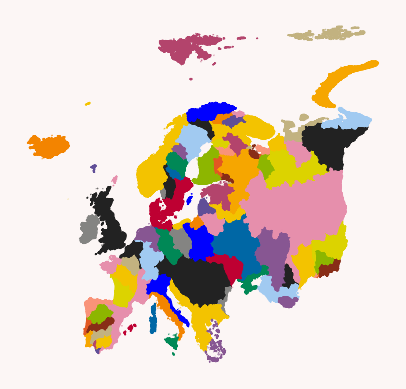

In [123]:
# Plotting the basins DataFrame on a map with customized colors based on the 'colors' column
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
basins.plot(ax=ax, edgecolor='face', color=basins['colors'])
ax.axis('off')
plt.show()

In [124]:
# Masking the raster data with the geometries of the basins
sa_array, clipped_transform = msk.mask(rst, [mapping(geom) for geom in basins.geometry.tolist()], crop=True)

# Adjusting the nodata value to ensure it's less than the minimum value in the masked array
sa_array, clipped_transform = msk.mask(rst, [mapping(geom) for geom in basins.geometry.tolist()], 
                                             crop=True, nodata=(np.amin(sa_array[0]) - 1))

# Calculating the value range of the masked array for color mapping purposes
value_range = np.amax(sa_array) + abs(np.amin(sa_array))

In [125]:
# Creating geometries for each unique MAIN_BAS using unary_union
geoms = [unary_union(basins.loc[basins['MAIN_BAS'] == poly_basin].geometry.tolist()) for poly_basin in basins.MAIN_BAS.unique().tolist()]

# Extracting the boundary of each geometry
geoms = [geom.boundary for geom in geoms]

In [126]:
print(geoms[:2])

[<MULTILINESTRING ((40.6 43.6, 40.6 43.6, 40.6 43.6, 40.6 43.6, 40.6 43.6, 40...>, <MULTILINESTRING ((44.2 46.2, 44.2 46.2, 44.2 46.2, 44.2 46.2, 44.2 46.2, 44...>]


In [127]:
# Creating a GeoDataFrame with unique MAIN_BAS values and their corresponding geometries
basins_poly = gpd.GeoDataFrame(pd.DataFrame({'Basin': basins.MAIN_BAS.unique().tolist()}), geometry=geoms)

<Axes: >

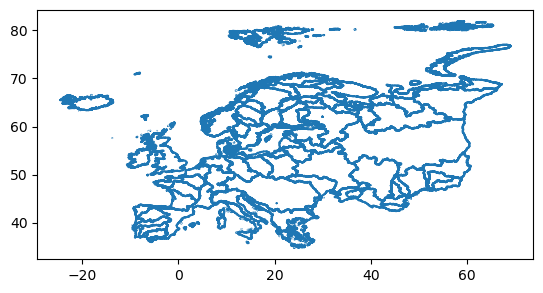

In [128]:
basins_poly.plot()

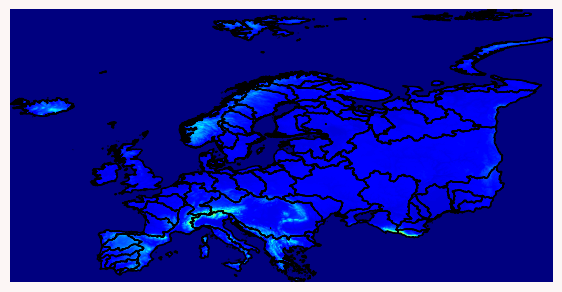

In [129]:
# Plotting the raster image and basins polygons on the same matplotlib figure
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(7, 14)

show(sa_array, ax=ax, transform=clipped_transform, cmap='jet')
basins_poly.plot(ax=ax, edgecolor='black', lw=1)
ax.axis('off')

plt.show()

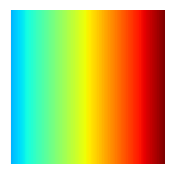

In [143]:
# Defining the color map for the Europe visualization
europe_min = 0
europe_max = 2500

our_cmap = plt.cm.jet

# Generating new colors by interpolating between 0.3 and 1 on the 'jet' color map
newcolors = our_cmap(np.linspace(0.3, 1, int((europe_max - europe_min) / 10)))

# Setting the background color to a light shade
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour

# Creating a new colormap with the interpolated colors
our_cmap = ListedColormap(newcolors)

# Defining the boundaries for the color map
bounds = np.arange(europe_min, europe_max, 10)
norm = BoundaryNorm(bounds, our_cmap.N)

# Creating a gradient image to display the color map
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.figure(figsize=(2, 2)) 
plt.imshow(gradient, aspect='auto', cmap=our_cmap)
plt.axis('off')
plt.show()

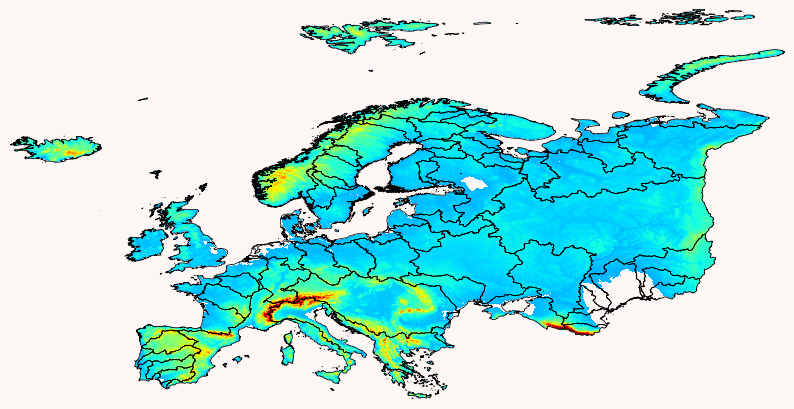

In [144]:
# Creating a visualization of Europe with the sa_array data masked by basin polygons
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 15)

show(sa_array, ax=ax, transform=clipped_transform, cmap=our_cmap, norm=norm)
basins_poly.plot(ax=ax, edgecolor='black', lw=0.5)

ax.axis('off')
plt.show()